In [2]:
import pandas as pd
import numpy as np

def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

In [3]:
pagerank_scores = pd.DataFrame.from_csv('../data/simulation/pagerank_scores_sim.txt', sep='\t')
subnets, disease_genes = read_implant_positions('../data/simulation/implant_positions.txt')

In [4]:
pr_nodes = [int(i) for i in pagerank_scores.index]
pagerank_scores[pagerank_scores.index.isin(subnets)]


,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
1.0,1.0,79,0.001858
0.0,0.0,330,0.000921
3.0,3.0,395,0.000833
2.0,2.0,743,0.000521
4.0,4.0,809,0.000513


In [5]:
subnets[subnets.isin([92]).any(axis=1)].shape

(0, 5)

In [6]:
pagerank_scores.head(300)[pagerank_scores.head(300).index.isin(disease_genes)].shape

(10, 3)

In [7]:
ranks = []
idx = []
for score in pagerank_scores.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        ranks.append(pagerank_scores.loc[score].Rank)
        idx.append(score)

In [8]:
pr_scores_subnets = pagerank_scores.loc[idx]
recovered_pr = pr_scores_subnets[pr_scores_subnets.Rank <= 300]
recovered_pr.shape

(56, 3)

# GCN

In [107]:
model_dir = '../data/GCN/training/2018_01_04_15_18_11/'
gcn_pred = pd.DataFrame.from_csv(model_dir + 'predictions.tsv', sep='\t')
gcn_pred.shape

(1019, 3)

In [108]:
recovered_diseasegenes_gcn = gcn_pred[gcn_pred.index.isin(disease_genes)]
recovered_diseasegenes_gcn[recovered_diseasegenes_gcn.Prob_pos > 0.5].shape

(23, 3)

In [109]:
gcn_idx = []
for score in gcn_pred.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        gcn_idx.append(score)

In [110]:
gcn_pred_for_subnets = gcn_pred.loc[gcn_idx]
gcn_pred_for_subnets.shape

(190, 3)

In [111]:
(gcn_pred.loc[gcn_idx].Prob_pos > .5).shape

(190,)

In [112]:
recovered_gcn = gcn_pred_for_subnets[gcn_pred_for_subnets.Prob_pos > .5]

In [113]:
recovered_gcn.shape, gcn_pred[gcn_pred.Prob_pos > 0.5].shape

((133, 3), (372, 3))

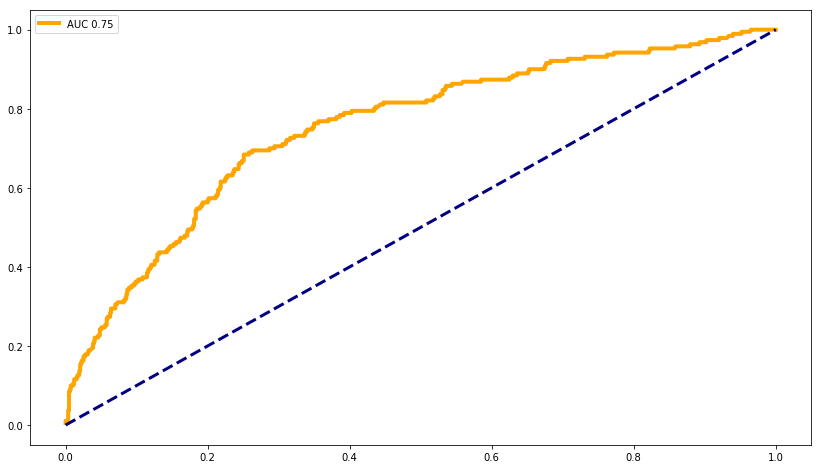

In [121]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
subnet_entries = subnets.values.flatten()
y_true = gcn_pred.index.isin(subnet_entries)
y_score = gcn_pred.Prob_pos
tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
auc = roc_auc_score(y_score=y_score, y_true=y_true)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, lw=4, color='orange', label='AUC {0:.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend()
fig.savefig(model_dir + 'roc_curve.png', dpi=300)

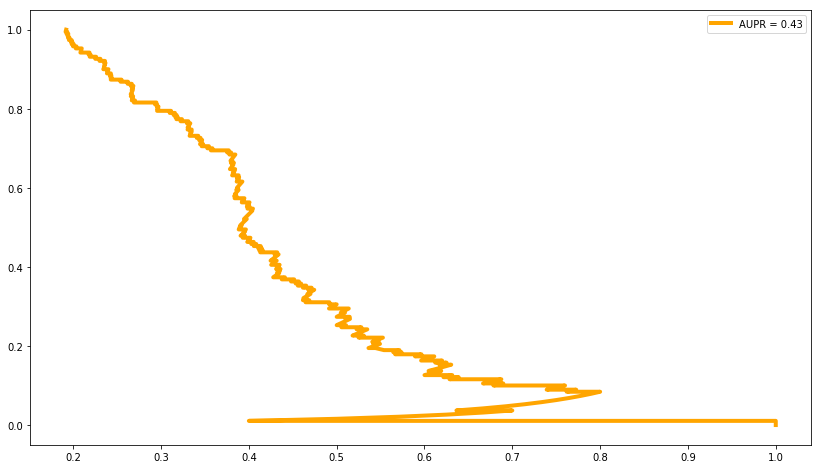

In [122]:
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_prec = average_precision_score(y_true, y_score)
pr, rc, _ = precision_recall_curve(y_true, y_score)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rc, lw=4, color='orange', label='AUPR = {0:.2f}'.format(avg_prec))
plt.legend()
fig.savefig(model_dir + 'prec_recall_curve.png', dpi=300)